we import some clmm modules

In [1]:
import sys
import os
import clmm

import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
from clmm import Cosmology
from clmm.support import mock_data as mock
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
import numpy as np
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from numpy import random
import chainconsumer
import scipy
from scipy.interpolate import interp1d
clmm.__version__

'0.9.3'

we import `clmm` module's core.

modules

In [2]:
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
from scipy.optimize import curve_fit

In [3]:
np.random.seed(22)

we define `astropy` and `ccl` cosmology object

In [4]:
mock_cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)

In [5]:
moo = clmm.Modeling(massdef = 'critical', delta_mdef = 200, halo_profile_model = 'nfw')
moo.set_cosmo(mock_cosmo)

we define the `Modeling` object `moo` to model the galaxy cluster.

we now define the type of desired profile : tangential reduced shear of Excess surface density for the stacking procedure by modifying the atribute. We use the method `Type` from the class to select DeltaSigma of reduced tangential shear.

In [6]:
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]

# Estimator of the stacked excess surface density

- The maximum likelihood estimator of the excess surface density in the radial bin $[R, R + \Delta R[$ is defined by

$$\widehat{\Delta\Sigma}_+(R) = \frac{1}{\sum\limits_{l,s = 1} w_{ls}}
     \sum\limits_{l,s= 1}w_{ls}\langle\Sigma_{{\rm crit}}(z_s, z_l)^{-1}\rangle^{-1}\epsilon_+^{s},$$ where $\epsilon_+^{s}$ is the tangential ellipticity of the background galaxy with index $s$ (as source) relative to the dark matter halo position with index $l$ (as lens).
     
- The critical surface mass density expresses as $\Sigma_{{\rm crit}}(z_s, z_l) = \frac{c^2}{4 \pi G} \frac{D_A(z_s)}{D_A(z_l) D_A(z_s, z_l)}$, where $D_A(z_l), D_A(z_s)$ are respectively the angular diameter distance to the lens and to the source in physical units, and $D_A(z_s, z_l)$ is the angular diameter distance between the lens and the source.


- The average $\langle\Sigma_{\rm crit}(z_s,z_l)^{-1}\rangle$ is defined as $\langle\Sigma_{\rm crit}(z_s,z_l)^{-1}\rangle = \int_{z_l + \delta}^{+\infty} d z_s\ p_{\rm photoz,s}(z_s)\ \Sigma_{\rm crit}(z_s,z_l)^{-1}$, where $p_{\rm photoz,s}$ is the photometric probability density function for the background galaxy with index $s$.

This equation can be re-written as

$$\widehat{\Delta\Sigma}_+(R) = \frac{1}{\sum\limits_{l = 1} W_{l}}
     \sum\limits_{l,s= 1}W_{l}\Delta\Sigma_l(R)$$
     
where $$\Delta\Sigma_l(R) = \frac{1}{\sum\limits_{s = 1} w_{ls}}
     \sum\limits_{s= 1}w_{ls}\langle\Sigma_{{\rm crit}}(z_s, z_l)^{-1}\rangle^{-1}\epsilon_+^{s}$$
     
and $$W_{l} = \sum\limits_{s= 1}w_{ls}$$

### Weights $w_s$

The quantities $w_{s}$ are the weights that maximise the sigmnal-to-noise ratio of the excess surface density estimator. They downweight the galaxies that are close in redshift to the cluster (where the lensing signal is weak). They include the lack of informations on both redshift and shape reconstruction for each background galaxies. 

- In the case where there is no error on the shape measurement (for the purpose of cosmoDC2 galaxies), the weight writes $w_{ls} = \langle\Sigma_{\rm crit}(z_s,z_l)^{-1}\rangle^{2}$,

- In the case of true redshift $z_s$, the PDF reduces to a Dirac function centered at $z_s$, giving the average $\langle\Sigma_{\rm crit}(z_l,z_s)^{-1}\rangle = \Sigma_{\rm crit}(z_l,z_s)^{-1} $ and the weight $w_{s} = \Sigma_{\rm crit}(z_s,z_l)^{-2}$,

We now define some redshift interval and input mass interval to select GalaxyCluster object in preselected galaxy catalogs from `cosmoDC2`

# Dark matter halo catalog for the stack

In [7]:
z_bin = [0.2,0.25]
logm_bin = [14, 14.1] #Solar Mass
logm_bin = np.array(logm_bin)
n_catalogs = 100
ngals = 10000

we define a set of selected cluster with given true masses ans true redshifts

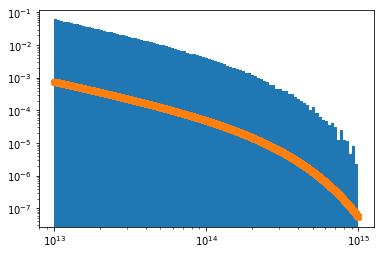

In [8]:
#could be function

lower_limit =13
upper_limit =15
nbinhist=n_catalogs
norm = (upper_limit-lower_limit)/nbinhist

M_star = 2.e14
b=4*10**(-5)
numsamp= 10**6 #input
numstep = 10**4

#define x range 1e12-1e15 in num steps
x = np.logspace(lower_limit,upper_limit,numstep)
#define y values from the function 
y = (b*(1/(x/M_star))*np.exp(-(x)/M_star))

#calculate cumulative sum of the y values (numpy)
y_cm = np.cumsum(y)
y_cm = y_cm-min(y_cm)
y_cm = y_cm/np.max(y_cm)

#invert x and y variables (flipping)and interpolate that function 
f = interp1d(y_cm,x , fill_value=(0,1))
#Generate N random numbers uniformly between 0 & 1: u_i~U(0,1)
ynew = np.random.random(numsamp)
#Using the Inverse of the CDF and the values u_i, compute x_i = F^-1(u_i)
x_samp = f(ynew) #return

#plot it to see the result
plt.hist(x_samp, bins=np.logspace(lower_limit,upper_limit,nbinhist),weights=np.repeat(numsamp/sum(y*x),numsamp)/norm)
plt.yscale('log')
plt.xscale('log')
plt.plot(x, y, 'o')
#plt.show()


#use that interpolated function to predict num samples



In [9]:
cluster_m=np.zeros(n_catalogs)
for k in range(n_catalogs):
    print(k)
    cluster_m[k]=x_samp[k]  #in M_sun
cluster_z = (z_bin[1] - z_bin[0])*np.random.random(n_catalogs) + z_bin[0]
lnc = abs(np.log(4) + 0.1*np.random.randn(n_catalogs))
concentration = 5.72/((1+cluster_z)**0.71)*(cluster_m/10.e14)**(-0.081)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [10]:
print(n_catalogs)
print(np.shape(cluster_m))

100
(100,)


Text(0, 0.5, '$c_{\\rm 200c}$')

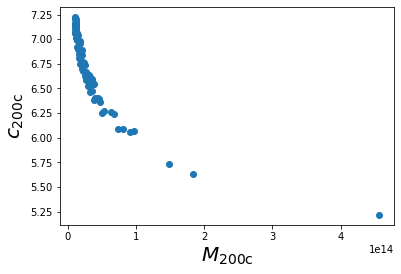

In [11]:
plt.scatter(cluster_m, concentration)
plt.xlabel(r'$M_{\rm 200c}$', fontsize = 20)
plt.ylabel(r'$c_{\rm 200c}$', fontsize = 20)

We add each galaxy catalogs that correponds to binning criteria to the `shear` object through the `Add(self,'file_name')` method.

In [12]:
shapenoise = 0.005

In [13]:
def excess_surface_density(single_catalog = None, radial_bin = None, sigma_c = None):
    r"""
    Attributes:
    -----------
    
    single_catalog : GalaxyCluster object
    
    radial_bin : liste
        radial bins to evaluate the binned excess surface density
    
    sigma_c : string 
        column name in the single_catalog for the critical surface mass density
        
    Returns:
    --------
    
    ds, r, sum_weights : array, array, array
        the binned excess surface density, the binned radius, the sum of weights w_ls in each radial bin

    """
    
    ds = np.zeros(len(radial_bin))
    
    r = np.zeros(len(radial_bin))
    
    sum_weights = np.zeros(len(radial_bin))
    
    for i, r_bin in enumerate(radial_bin):

        mask = (single_catalog.galcat['R'] > r_bin[0])*(single_catalog.galcat['R'] < r_bin[1])
        
        w_ls = 1./single_catalog.galcat[sigma_c][mask]**2
        
        ds[i] = np.average(single_catalog.galcat['et'][mask]*single_catalog.galcat[sigma_c][mask], weights = w_ls)
        
        r[i] = np.average(single_catalog.galcat['R'][mask])
        
        sum_weights[i] = np.sum( w_ls )
        
    return ds, r, sum_weights

## Generating background galaxy catalogs & estimating individual shear profile

We use `clmm` to generate `n_catalogs` background galaxy catalogs for each clusters in the sample. We estimate the individual shear profile and store the individual data:

- `ds_single`, `r_single` the single excess surface density extimated in the radial bins, and the average radius in each radial bins
- `W_l` the sum of the weight `w_ls` for each lens-source pairs in each radial bins.
We difine two possible weights `w_ls`, first using true redshifts of sources, second using the photometric redshift pdf for each sources as presented above. In the function `excess_surface_density`, the argument `sigma_c` will be computed using the true redshift of galaxy, of it will be given by $\langle\Sigma_{\rm crit}(z_s,z_l)^{-1}\rangle^{-1}$.

In [14]:
add_photoz_weights = True

In [15]:
%time
GalaxyCluster = []

for i in range(n_catalogs):
    
    if i%10 == 0: print(i)
    
    noisy_data_z = mock.generate_galaxy_catalog(cluster_m[i], cluster_z[i], concentration[i], 
                                                cosmo, 
                                                zsrc = 'chang13', 
                                                Delta_SO=200, 
                                                massdef='critical',
                                                halo_profile_model='nfw', 
                                                zsrc_min=cluster_z[i] + 0.1,
                                                zsrc_max=3., 
                                                field_size=10., 
                                                shapenoise=shapenoise, 
                                                photoz_sigma_unscaled=0.05, 
                                                ngals=ngals)
    
    if add_photoz_weights == True:
        
        pzbins_constant = np.linspace(0,3,30)
        
        sigma_crit_1 = 1./mock_cosmo.eval_sigma_crit(cluster_z[i], pzbins_constant)

        photoz_matrix = np.zeros([len(noisy_data_z), len(pzbins_constant)])
        
        r"""
        I added this line since the photoz pdf is not computed on a constant redshift grid. simps integral can be optimized using the same x-axis for multiple integrals.
        =================================================================================================================================================================
        """

        for f in range(len(noisy_data_z['id'])):

            photoz_matrix[f,:] = np.interp(pzbins_constant, noisy_data_z['pzbins'][f], noisy_data_z['pzpdf'][f])
            
        r"""
        =================================================================================================================================================================
        """

        unormed_integral = scipy.integrate.simps(photoz_matrix * sigma_crit_1, x = pzbins_constant, axis = 1)

        norm = scipy.integrate.simps(photoz_matrix, x = pzbins_constant, axis = 1)

        noisy_data_z['sigma_c_photoz'] = (unormed_integral/norm)**(-1)
        
    
    cl = clmm.GalaxyCluster('mock_cluster', 0, 0, cluster_z[i], noisy_data_z)
    
    cl.compute_tangential_and_cross_components(geometry="flat",
                                              shape_component1='e1', shape_component2='e2', 
                                              tan_component='et', cross_component='ex',
                                              add=True, 
                                              is_deltasigma = False, 
                                              cosmo = cosmo)
    
    cl.galcat['R'] = mock_cosmo.eval_da_z1z2(0,cluster_z[i])*cl.galcat['theta']
    
    ang, phi = clmm.dataops._compute_lensing_angles_flatsky(cl.ra, cl.dec, cl.galcat['ra'], cl.galcat['dec'])

    cl.galcat['phi'] = np.array(phi)
    
    cl.galcat['sigma_c_true'] = mock_cosmo.eval_sigma_crit(cluster_z[i], cl.galcat['ztrue'])
    
    GalaxyCluster.append(cl)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 3.1 µs
0


/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_l

10


/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_l

20


/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_l

30


/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_l

40


/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_l

50


/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_l

60


/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_l

70


/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_l

80


/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_l

90


/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_l

In [16]:
print(cl.galcat['ra'])

         ra         
--------------------
 -0.2960709954196609
 0.23489837507816144
 0.13885006582360834
 -0.0922675098143253
-0.31134451924749207
-0.09484629779755292
-0.40308405792338775
                 ...
  0.1246312692950008
 -0.3513025432492723
  0.0967734740030166
0.007395075202604557
-0.03279604200647849
 0.05154493257667135
-0.13276801353784778
Length = 10000 rows


## Estimating single excess surface density profiles

# $$\widehat{\Delta\Sigma}_+(R) = \frac{1}{\sum\limits_{l = 1} W_{l}}
     \sum\limits_{l,s= 1}W_{l}\Delta\Sigma_l(R)$$

In [17]:
new_bins = np.logspace(np.log10(0.4), np.log10(5), 20)
radial_bin = [[new_bins[s],new_bins[s+1]] for s in range(len(new_bins)-1)]

In [18]:
names = ['ds_single', 'r_single', 'W_l','c', 'z', 'mass']

Stack_file_true = {name : [] for name in names}

Stack_file_photoz = {name : [] for name in names}

for i in range(n_catalogs):
    
    ds_single, r_single, sum_weights_single = excess_surface_density(single_catalog = GalaxyCluster[i], radial_bin = radial_bin, sigma_c = 'sigma_c_true')
    
    data_to_store = [ds_single, r_single, sum_weights_single, concentration[i], cluster_z[i], cluster_m[i]]
    
    for d, name in enumerate(names):
        
        Stack_file_true[name].append(data_to_store[d])
        
    ds_single, r_single, sum_weights_single = excess_surface_density(single_catalog = GalaxyCluster[i], radial_bin = radial_bin, sigma_c = 'sigma_c_photoz')
    
    data_to_store = [ds_single, r_single, sum_weights_single, concentration[i], cluster_z[i], cluster_m[i]]
    
    for d, name in enumerate(names):
        
        Stack_file_photoz[name].append(data_to_store[d])

# Stacked excess surface density profile : true z and photoz

## Stacked profile

We estimate the mean excess surface density profile `ds_mean` and the mean radius `r_mean`

In [19]:
#stacked excess surface density profile - true redshift case
print(Stack_file_true['W_l'])
ds_mean_true = np.average(Stack_file_true['ds_single'], weights = Stack_file_true['W_l'], axis = 0)
r_mean_true = np.average(Stack_file_true['r_single'], weights = None, axis = 0)

#stacked excess surface density profile - photoz redshift case
ds_mean_photoz = np.average(Stack_file_photoz['ds_single'], weights = Stack_file_photoz['W_l'], axis = 0)
r_mean_photoz = np.average(Stack_file_photoz['r_single'], weights = None, axis = 0)

[array([1.01786792e-30, 1.68167536e-30, 2.23866008e-30, 3.02660698e-30,
       3.65429014e-30, 4.00312494e-30, 7.68418145e-30, 8.97940671e-30,
       1.19991910e-29, 1.42907133e-29, 1.93769742e-29, 2.90525785e-29,
       3.38746788e-29, 4.21213287e-29, 5.95515810e-29, 7.57138018e-29,
       9.85808433e-29, 1.27559532e-28, 1.60127211e-28]), array([1.50319538e-30, 2.03444894e-30, 1.84343915e-30, 3.89008998e-30,
       3.81993400e-30, 5.52404744e-30, 5.50002512e-30, 8.59465696e-30,
       1.09736971e-29, 1.58388491e-29, 1.82804163e-29, 2.59102384e-29,
       3.33192802e-29, 4.33505959e-29, 5.89680308e-29, 7.17373438e-29,
       9.61429757e-29, 1.22725519e-28, 1.63618984e-28]), array([1.61755353e-30, 2.28065656e-30, 2.85405032e-30, 3.23321114e-30,
       3.58734080e-30, 6.21420265e-30, 8.61014824e-30, 9.07706329e-30,
       1.35017379e-29, 1.62530614e-29, 2.22775051e-29, 2.85061865e-29,
       3.70598358e-29, 4.46907580e-29, 5.28335369e-29, 7.59211829e-29,
       9.96033674e-29, 1.27998005

## Covariance matrix

We compute the sample covariance matrix defined as
$$
    (\mathbf{C}^{\rm sample})_{i,j} = \frac{1}{N_{\rm cluster} - 1}\sum_{k = 0}^{N_{\rm cluster}}[\Delta\Sigma^k(R_i) - \overline{\Delta\Sigma}(R_i)] [\Delta\Sigma^k(R_j) - \overline{\Delta\Sigma}(R_j)],
$$
and $\overline{\Delta\Sigma}(R_i)$ is denoted by
$$
    \overline{\Delta\Sigma}(R_i) = \frac{1}{N_{\rm cluster}}\sum_{k = 0}^{N_{\rm boot}} \Delta\Sigma^k(R_i).
$$

In [20]:
#covariance matrix
sample_covariance_stack_true = np.cov(np.array(Stack_file_true['ds_single']).T)/n_catalogs
sample_covariance_stack_photoz = np.cov(np.array(Stack_file_photoz['ds_single']).T)/n_catalogs

# Single cluster : Generating background galaxy catalogs

To make standard comparison with the stack analysis, we use also consider a single cluster

In [21]:
noisy_data_z_single = mock.generate_galaxy_catalog(np.mean(cluster_m), np.mean(cluster_z), np.mean(concentration), cosmo, 
                                                zsrc = 'chang13', 
                                                Delta_SO=200, 
                                               massdef='critical',
                                               halo_profile_model='nfw', zsrc_min=np.mean(cluster_z) + 0.1,
                           zsrc_max=3., field_size=10., shapenoise=shapenoise, photoz_sigma_unscaled=0, ngals=ngals)

cl_single = clmm.GalaxyCluster('mock_cluster', 0., 0., np.mean(cluster_z), noisy_data_z_single)

cl_single.compute_tangential_and_cross_components(geometry="flat",
                                                  shape_component1='e1', shape_component2='e2', 
                                                  tan_component='et', cross_component='ex',
                                                  add=True, is_deltasigma = False, cosmo = cosmo)

cl_single.galcat['R'] = mock_cosmo.eval_da_z1z2(0,np.mean(cluster_z))*cl_single.galcat['theta']

ang, phi = clmm.dataops._compute_lensing_angles_flatsky(cl_single.ra, cl_single.dec, cl_single.galcat['ra'], cl_single.galcat['dec'])

cl_single.galcat['phi'] = np.array(phi)

cl_single.galcat['sigma_c'] = mock_cosmo.eval_sigma_crit(np.mean(cluster_z), cl_single.galcat['z'])

# Single cluster : excess surface density

## Excess surface density profile

In [22]:
#excess surface density profile
ds_single,r_single,sum_weight_single = excess_surface_density(single_catalog = cl_single, radial_bin = radial_bin, sigma_c = 'sigma_c')

## Covariance matrix

We estimate the single excess surface density covariance matrix by the delete-1 Jackknife method : We split the sky area arround the cluster center in $N_{\rm JK}$ regions, and we exclude one region at a time and re-estimate the excess surface density profile:, the covariance writes

$$
    (\mathbf{C}^{\rm JK})_{i,j} = \frac{N_{\rm JK} - 1}{N_{\rm JK}}\sum_{k = 0}^{N_{\rm JK}}[\Delta\Sigma^k(R_i) - \overline{\Delta\Sigma}(R_i)] [\Delta\Sigma^k(R_j) - \overline{\Delta\Sigma}(R_j)]
$$
with the mean 
$$
    \overline{\Delta\Sigma}(R_i) = \frac{1}{N_{\rm JK}}\sum_{k = 0}^{N_{\rm JK}} \Delta\Sigma^k(R_i).
$$

In [23]:
def jackknife(single_catalog = None, N_jk = None):
    
    r"""
    Attributes:
    -----------
    single_catalog : GalaxyCluster object
        GalaxyCluster object of a single cluster 
    N_jk : int
        number of jackknife regions
        
    Returns:
    --------
    cov : array
        Jackknife delete-1 covariance matrix
    
    """
    
    phi = np.linspace(-np.pi, np.pi, N_jk + 1)
    
    phi_bin = binning(phi)
    
    gt = []
    
    mask_list_in = [(phi_[0] < single_catalog.galcat['phi'])*(single_catalog.galcat['phi'] < phi_[1]) for phi_ in phi_bin]
    
    for s, phi_ in enumerate(phi_bin):
        
        mask_in = mask_list_in[s]
        
        mask_out = np.invert(mask_in)
        
        plt.scatter(single_catalog.galcat['ra'][mask_in], single_catalog.galcat['dec'][mask_in], s = 1)
        
        data_cut = single_catalog.galcat[mask_out]
        
        cl_cut_jack = clmm.GalaxyCluster('Stack', single_catalog.ra, single_catalog.dec, single_catalog.z, single_catalog.galcat[mask_out])
        
        ds, r, sum_weights = excess_surface_density(single_catalog = cl_cut_jack, radial_bin = radial_bin, sigma_c = 'sigma_c')
        
        gt.append(ds)

    gt = np.array(gt)
    
    cov = np.cov(gt.T)*(N_jk-1)**2/N_jk
    
    plt.xlabel('ra')
    plt.ylabel('dec')
    plt.axis('equal')
        
    return cov

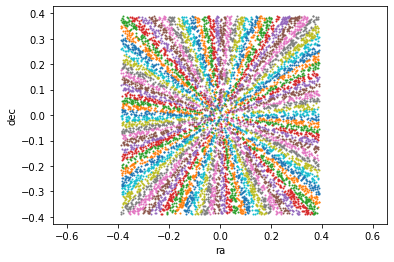

In [24]:
#Jackknife covariance matrix
cov_single = jackknife(single_catalog = cl_single, N_jk = 100)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


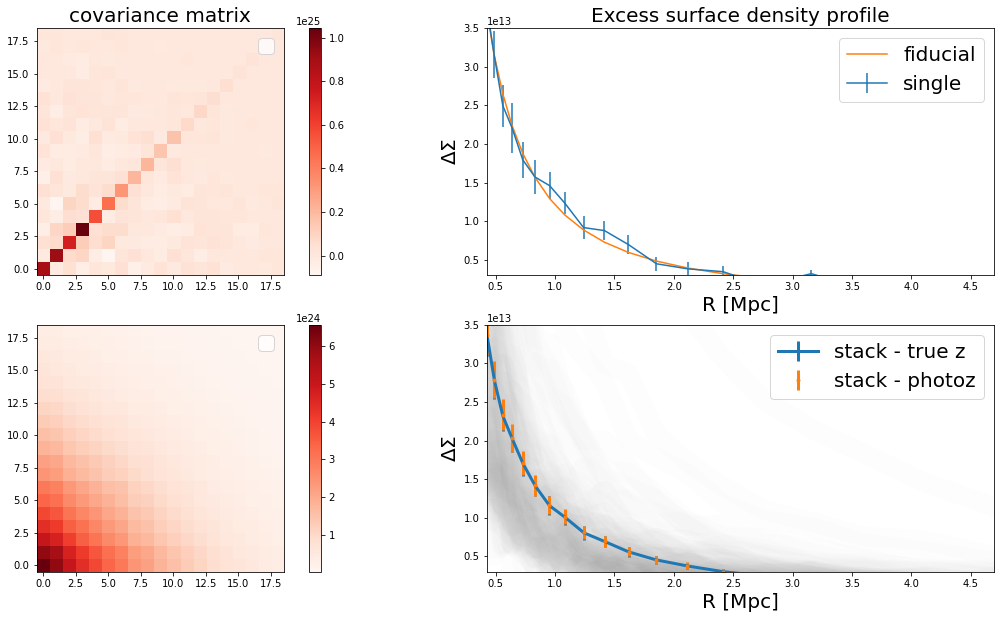

<Figure size 1440x720 with 0 Axes>

In [25]:
fig, axs = plt.subplots(2,2, figsize = (20,10))
#axs[0,0].imshow(np.corrcoef(cov_ss), vmin = -1,, cmap = 'bwr', origin = 'lower')
min_value = min(sample_covariance_stack_true.flatten())
im = axs[0,0].imshow(cov_single, cmap = 'Reds', origin = 'lower', label = 'single-jackknife')
plt.colorbar(im, ax=axs[0,0])
axs[0,1].errorbar(r_single,ds_single, np.sqrt(cov_single.diagonal()), label = 'single')
moo.set_concentration(concentration.mean())
moo.set_mass(cluster_m.mean())
axs[0,1].plot(r_single,moo.eval_excess_surface_density(r_single, cluster_z.mean()), label = 'fiducial')
axs[0,1].set_ylim(0.3*1e13, 3.5*1e13)

im = axs[1,0].imshow(sample_covariance_stack_true, cmap = 'Reds', origin = 'lower' ,label = 'stack-sample')
plt.colorbar(im, ax=axs[1,0])

plt.figure(figsize = (20,10))
for i in range(n_catalogs):
    axs[1,1].plot(Stack_file_true['r_single'][i], Stack_file_true['ds_single'][i], alpha = 0.01, c = 'grey', linewidth =20)
axs[1,1].errorbar(r_mean_true,ds_mean_true, np.sqrt(sample_covariance_stack_true.diagonal()), linewidth = 3, label = 'stack - true z')
axs[1,1].errorbar(r_mean_photoz,ds_mean_photoz, np.sqrt(sample_covariance_stack_photoz.diagonal()), linewidth = 3,fmt = '.', label = 'stack - photoz')
axs[1,1].set_ylim(0.3*1e13, 3.5*1e13)

axs[0,0].set_title('covariance matrix', fontsize = 20)
axs[0,1].set_title('Excess surface density profile', fontsize = 20)
for i in range(2):
    axs[i,1].set_xlim(min(r_single), max(r_single))
    axs[i,1].set_ylim(0.3*1e13, 3.5*1e13)
    axs[i,1].set_xlabel('R [Mpc]', fontsize = 20)
    axs[i,1].set_ylabel(r'$\Delta\Sigma$', fontsize = 20)
    
for i in range(2):
    for j in range(2):
        axs[i,j].legend(fontsize = 20)

# Stack VS single excess surface density : Fitting cluster mass and concentration

We fit the cluster mass and concentration using the `emcee` package 

In [26]:
def lnL(theta, r, ds, cov, z):
    
    logm, c = theta
    
    if c < 0.01: return -np.inf

    moo.set_mass(10**logm)
    
    moo.set_concentration(c)
    
    y_th = moo.eval_excess_surface_density(r,z)
    
    delta = (y_th - ds)
    
    inv_cov = np.linalg.inv(cov)
    
    lnL_ds = -0.5*np.sum(delta*inv_cov.dot(delta))
    
    return lnL_ds

In [27]:
import emcee
initial = [np.log10(np.mean(cluster_m)),np.mean(concentration)]
npath = 500
nwalkers = 10
pos = initial + 0.01 * np.random.randn(nwalkers, len(initial))
nwalkers, ndim = pos.shape
sampler_single = emcee.EnsembleSampler(nwalkers, ndim, lnL, args = (r_single, ds_single, cov_single, np.mean(cluster_z)))
print('Single cluster : running...')
sampler_single.run_mcmc(pos, npath, progress=True);

Single cluster : running...


100%|████████████████████████████████████████| 500/500 [00:01<00:00, 276.87it/s]


In [28]:
print('Stack true z : running...')
sampler_stack_true = emcee.EnsembleSampler(nwalkers, ndim, lnL, args = (r_mean_true, ds_mean_true, sample_covariance_stack_true, np.mean(cluster_z)))
sampler_stack_true.run_mcmc(pos, npath, progress=True);

Stack true z : running...


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 249.95it/s]


In [29]:
print('Stack photoz : running...')
sampler_stack_photoz = emcee.EnsembleSampler(nwalkers, ndim, lnL, args = (r_mean_photoz, ds_mean_photoz, sample_covariance_stack_photoz, np.mean(cluster_z)))
sampler_stack_photoz.run_mcmc(pos, npath, progress=True);

Stack photoz : running...


100%|████████████████████████████████████████| 500/500 [00:01<00:00, 251.35it/s]


In [30]:
#my data from my notebook
difference_noisy_zdistrib=np.load('difference_noisy_zdistrib.npy')
std_noisy_zdistrib=np.load('std_noisy_zdistrib.npy')

In [31]:
#mytry on the emcee
'''
print('notstack photoz : running...')
sampler_notstack_photoz = emcee.EnsembleSampler(nwalkers, ndim, lnL, args = (np.linspace(-5, 5, 1000), difference_noisy_zdistrib, std_noisy_zdistrib, np.mean(cluster_z)))
sampler_notstack_photoz.run_mcmc(pos, npath, progress=True);
'''

"\nprint('notstack photoz : running...')\nsampler_notstack_photoz = emcee.EnsembleSampler(nwalkers, ndim, lnL, args = (np.linspace(-5, 5, 1000), difference_noisy_zdistrib, std_noisy_zdistrib, np.mean(cluster_z)))\nsampler_notstack_photoz.run_mcmc(pos, npath, progress=True);\n"

Text(0, 0.5, '$c_{200c}$')

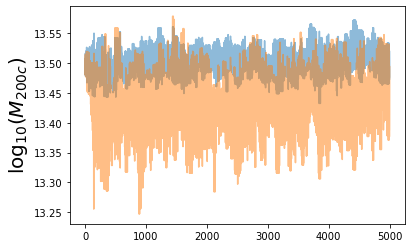

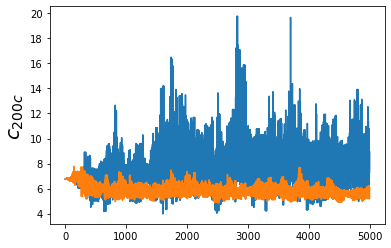

In [32]:
flat_sample_stack_pre_cut = sampler_stack_true.get_chain(discard = 0, thin = 1, flat = True)
flat_sample_single_pre_cut = sampler_single.get_chain(discard = 0, thin = 1, flat = True)
plt.plot(flat_sample_single_pre_cut[:,0],alpha=0.5)
plt.plot(flat_sample_stack_pre_cut[:,0],alpha=0.5)
plt.ylabel(r'$\log_{10}(M_{200c})$', fontsize= 20)
plt.figure()
plt.plot(flat_sample_single_pre_cut[:,1])
plt.plot(flat_sample_stack_pre_cut[:,1])
plt.ylabel(r'$c_{200c}$', fontsize= 20)

In [33]:
discard = 300
thin = 20

In [34]:
flat_sample_stack_true = sampler_stack_true.get_chain(discard = discard, thin = thin, flat = True)
flat_sample_stack_photoz = sampler_stack_photoz.get_chain(discard = discard, thin = thin, flat = True)
#mytry does not work. so far
#flat_sampler_notstack_photoz=sampler_notstack_photoz.get_chain(discard = discard, thin = thin, flat = True)

In [36]:
#save everything for the other notebook
np.save('flat_sample_stack_true',flat_sample_stack_true)
np.save('flat_sample_stack_photoz',flat_sample_stack_photoz)
#np.save('flat_sample_stack_photoz_delta',flat_sample_stack_photoz_delta)
np.save('cluster_m',cluster_m)
np.save('sample_covariance_stack_photoz',sample_covariance_stack_photoz)

In [37]:
flat_sample_single = sampler_single.get_chain(discard = discard, thin = thin, flat = True)

In [38]:
#flat_sample_stack_true.shape, flat_sample_single.shape

In [39]:
labels = [r'$\log_{10} M_{\rm 200c}$',r'$c_{\rm 200c}$', ]

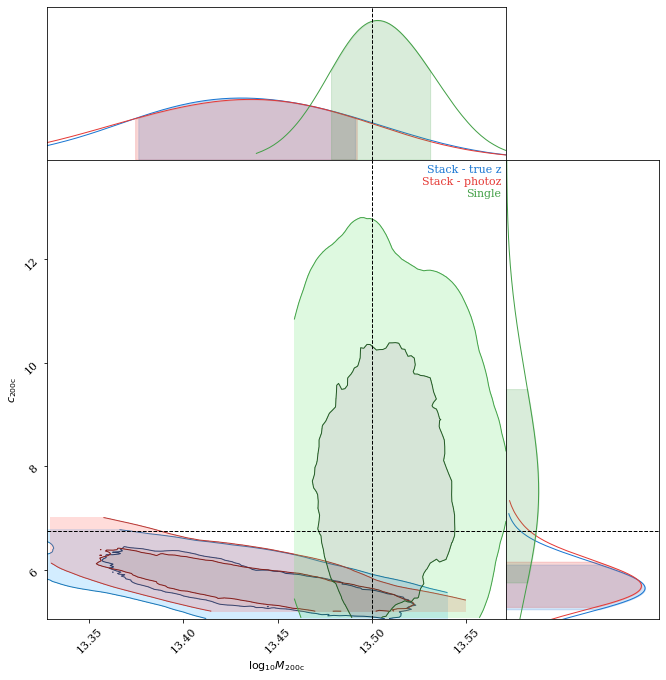

In [41]:
import numpy as np
from chainconsumer import ChainConsumer

mean = [np.log10(np.mean(cluster_m)),np.mean(concentration)]
c = ChainConsumer()
c.add_chain(flat_sample_stack_true, parameters=labels, name = 'Stack - true z')
c.add_chain(flat_sample_stack_photoz, parameters=labels, name = 'Stack - photoz')
c.add_chain(flat_sample_single, parameters=labels, name = 'Single')
c.configure (kde = True,colors=['b', 'r','g'], shade=True, shade_alpha=0.2, bar_shade=True, label_font_size=11, sigma2d=False, sigmas = [1, 2], spacing = 0.0, tick_font_size=11, usetex=False)
plot_args = {}
plot_args['truth'] = mean
fig = c.plotter.plot(**plot_args)
fig.set_size_inches(10, 10)
#print(flat_sample_stack_true)
#print(flat_sample_stack_photoz[:,[0]]-flat_sample_stack_true[:,[0]])
#print(flat_sample_stack_true[:,[0]])
#print(flat_sample_single)

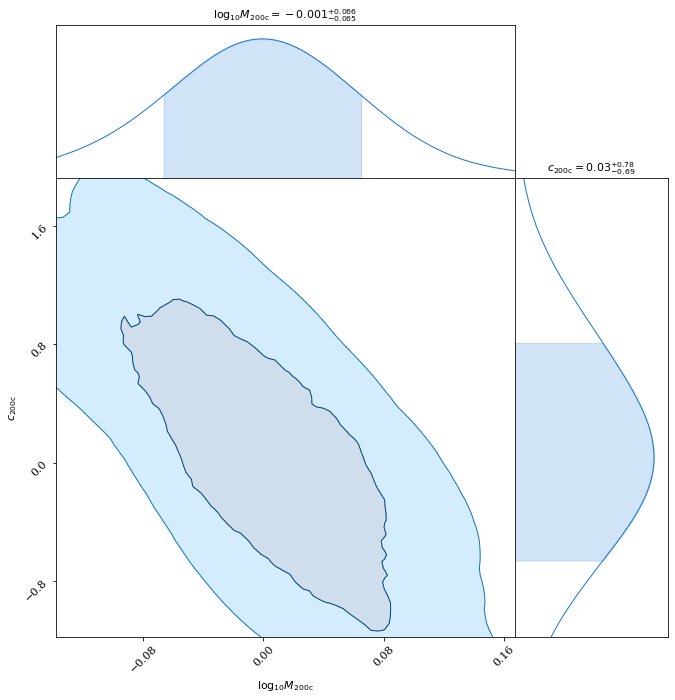

In [42]:
mean = [np.log10(np.mean(cluster_m)),np.mean(concentration)]
c = ChainConsumer()
c.add_chain(flat_sample_stack_photoz-flat_sample_stack_true, parameters=labels, name = 'Stack - true z')
c.configure (kde = True,colors=['b', 'r','g'], shade=True, shade_alpha=0.2, bar_shade=True, label_font_size=11, sigma2d=False, sigmas = [1, 2], spacing = 0.0, tick_font_size=11, usetex=False)
plot_args = {}
plot_args['truth'] = mean
fig = c.plotter.plot(**plot_args)
fig.set_size_inches(10, 10)

In [ ]:
'''
Maybe for later use
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
from math import log, exp
difference_noisy_singlez = np.log10(flat_sample_stack_pre_cut)-np.log10(cluster_m)
#print(difference)
std_noisy_singlez = (1/np.log(10))*np.array(m_est_err_noisy_singlez)/np.array(m_est_noisy_singlez)
#print(mean)
#print(std)
x_min=-5
x_max=5

x = np.linspace(x_min, x_max, 1000)
ysum_noisy_singlez = 0

for k in range(num):

    y_noisy_singlez = scipy.stats.norm.pdf(x,difference_noisy_singlez[k],std_noisy_singlez[k])
    #print(y[k])
    #print(mean[k])
    #print(std[k])
    ysum_noisy_singlez = ysum_noisy_singlez + y_noisy_singlez
    
    #plt.plot(x,y, color='coral')

   

    plt.plot(x,y_noisy_singlez, color='coral',alpha=0.5)
#print(ysum)

plt.plot(x,ysum_noisy_singlez/200, color='blue')
plt.xlabel('$\Delta$M')
plt.ylabel('N')

#plt.plot(y,z)

plt.show()
#print(mean)
#print(std)
'''